## Installing necessary packages

In [15]:
!pip install ultralytics roboflow mlflow pyngrok --quiet

## Importing necessary packages

In [16]:
import mlflow
from roboflow import Roboflow
from ultralytics import YOLO
import os

In [ ]:
# Copying the runs folder from the drive
!cp -r /content/drive/MyDrive/runs /content

## Setting up mlflow using pyngrok

In [17]:
mlflow.set_experiment("YOLOv8_PascalVOC2012")

<Experiment: artifact_location='file:///content/mlruns/732453432473962449', creation_time=1762168737825, experiment_id='732453432473962449', last_update_time=1762168737825, lifecycle_stage='active', name='YOLOv8_PascalVOC2012', tags={}>

In [18]:
from google.colab import userdata
ngrok_token = userdata.get("ngrokToken")
roboflow_token = userdata.get("roboflow")

In [19]:
# !pkill -f ngrok
# !pkill -f mlflow

In [21]:
get_ipython().system_raw("mlflow ui --port 2000 --host 0.0.0.0 --serve-artifacts &")
mlflow.set_tracking_uri("http://localhost:2000")
from pyngrok import ngrok
ngrok.set_auth_token(ngrok_token)

In [22]:
public_url = ngrok.connect(2000).public_url
print(public_url)

https://dino-advisory-unprimitively.ngrok-free.dev


## Downloading Pascal VOC 2012 dataset from roboflow

In [23]:
rf = Roboflow(api_key=roboflow_token)
project = rf.workspace("jacob-solawetz").project("pascal-voc-2012")
version = project.version(1)
dataset = version.download("yolov8")  # YOLOv8 compatible format

loading Roboflow workspace...
loading Roboflow project...


In [24]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  train  valid


## Building and training the model

In [25]:
model = YOLO("yolov8n.pt")

In [26]:
with mlflow.start_run(run_name="YOLOv8n_PascalVOC2012"):

    # Log parameters
    mlflow.log_param("model", "YOLOv8n")
    mlflow.log_param("dataset", "PascalVOC2012")
    mlflow.log_param("epochs", 10)
    mlflow.log_param("img_size", 640)

    # Training the model
    results = model.train(
        data=os.path.join(dataset.location, "data.yaml"),
        epochs=10,
        imgsz=640,
        batch=16,
        project="runs/train",
        name="exp",
        exist_ok=True
    )

    # Logging metrics from the last epoch
    metrics = model.val()
    mp, mr, map50, map = metrics.box.mean_results()
    f1 = 2 * (mp * mr) / (mp + mr + 1e-6)

    mlflow.log_metrics({
        "Precision": mp,
        "Recall": mr,
        "F1": f1,
        "mAP50": map50,
        "mAP50-95": map
    })

    # Logging trained weights
    mlflow.log_artifact("runs/train/exp/weights/best.pt")

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Pascal-VOC-2012-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

2025/11/03 12:15:15 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/03 12:15:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(92c08900c69d497c998bef38b5d00c31) to http://localhost:2000
MLflow: disable with 'yolo settings mlflow=False'
WARNING ⚠️ MLflow: Failed to initialize: API request to http://localhost:2000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='localhost', port=2000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))
WARNING ⚠️ MLflow: Not tracking this run
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/runs/train/exp
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/10      2.16G     0.9934      2.778      1.285         15       

In [28]:
from ultralytics.utils.plotting import plot_results

plot_results(file='runs/train/exp/results.csv')  # path to the training log

## Visualizing various metrics of the model

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


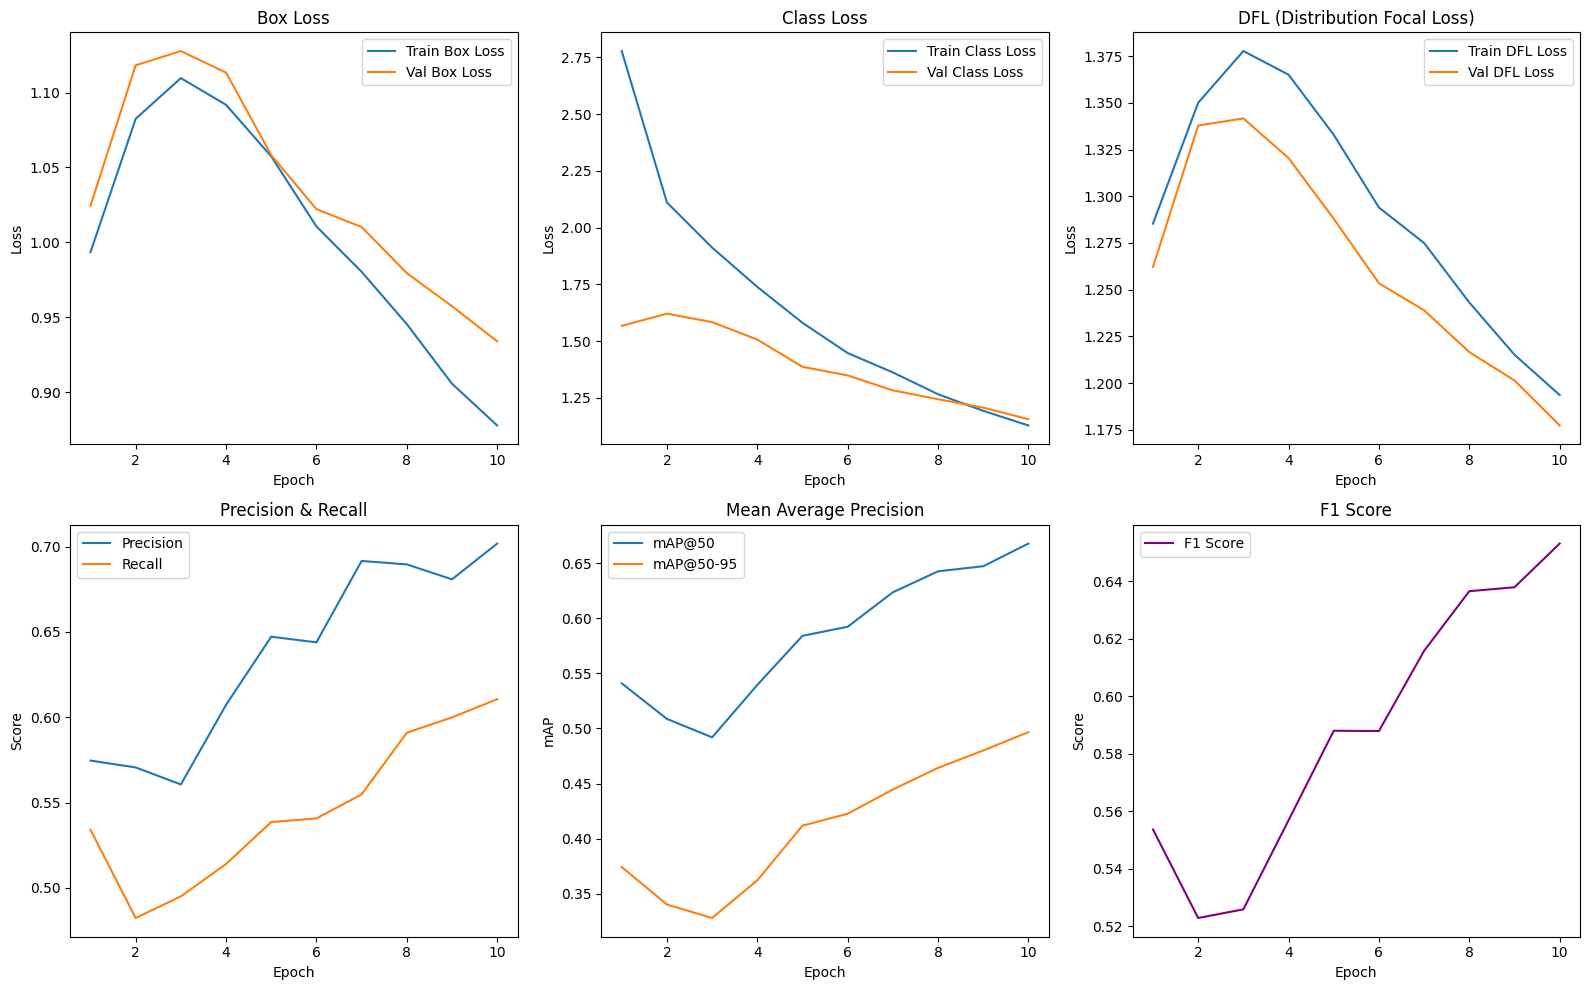

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "runs/train/exp/results.csv"

df = pd.read_csv(csv_path)

print("Available columns:", df.columns.tolist())

# Computing F1 score for each epoch
precision = df['metrics/precision(B)']
recall = df['metrics/recall(B)']
f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)  # small epsilon to avoid divide-by-zero

plt.figure(figsize=(16, 10))

# Training & Validation Box Loss
plt.subplot(2, 3, 1)
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.title('Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training & Validation Class Loss
plt.subplot(2, 3, 2)
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.title('Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Objectness Loss
plt.subplot(2, 3, 3)
plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
plt.title('DFL (Distribution Focal Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Precision and Recall
plt.subplot(2, 3, 4)
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.title('Precision & Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# mAP50 and mAP50-95
plt.subplot(2, 3, 5)
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95')
plt.title('Mean Average Precision')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()

# F1 Score
plt.subplot(2, 3, 6)
plt.plot(df['epoch'], f1_score, label='F1 Score', color='purple')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

## Testing on custom data


image 1/1 /content/3example.jpg: 480x640 1 motorbike, 1 person, 1 train, 9.5ms
Speed: 5.4ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict26


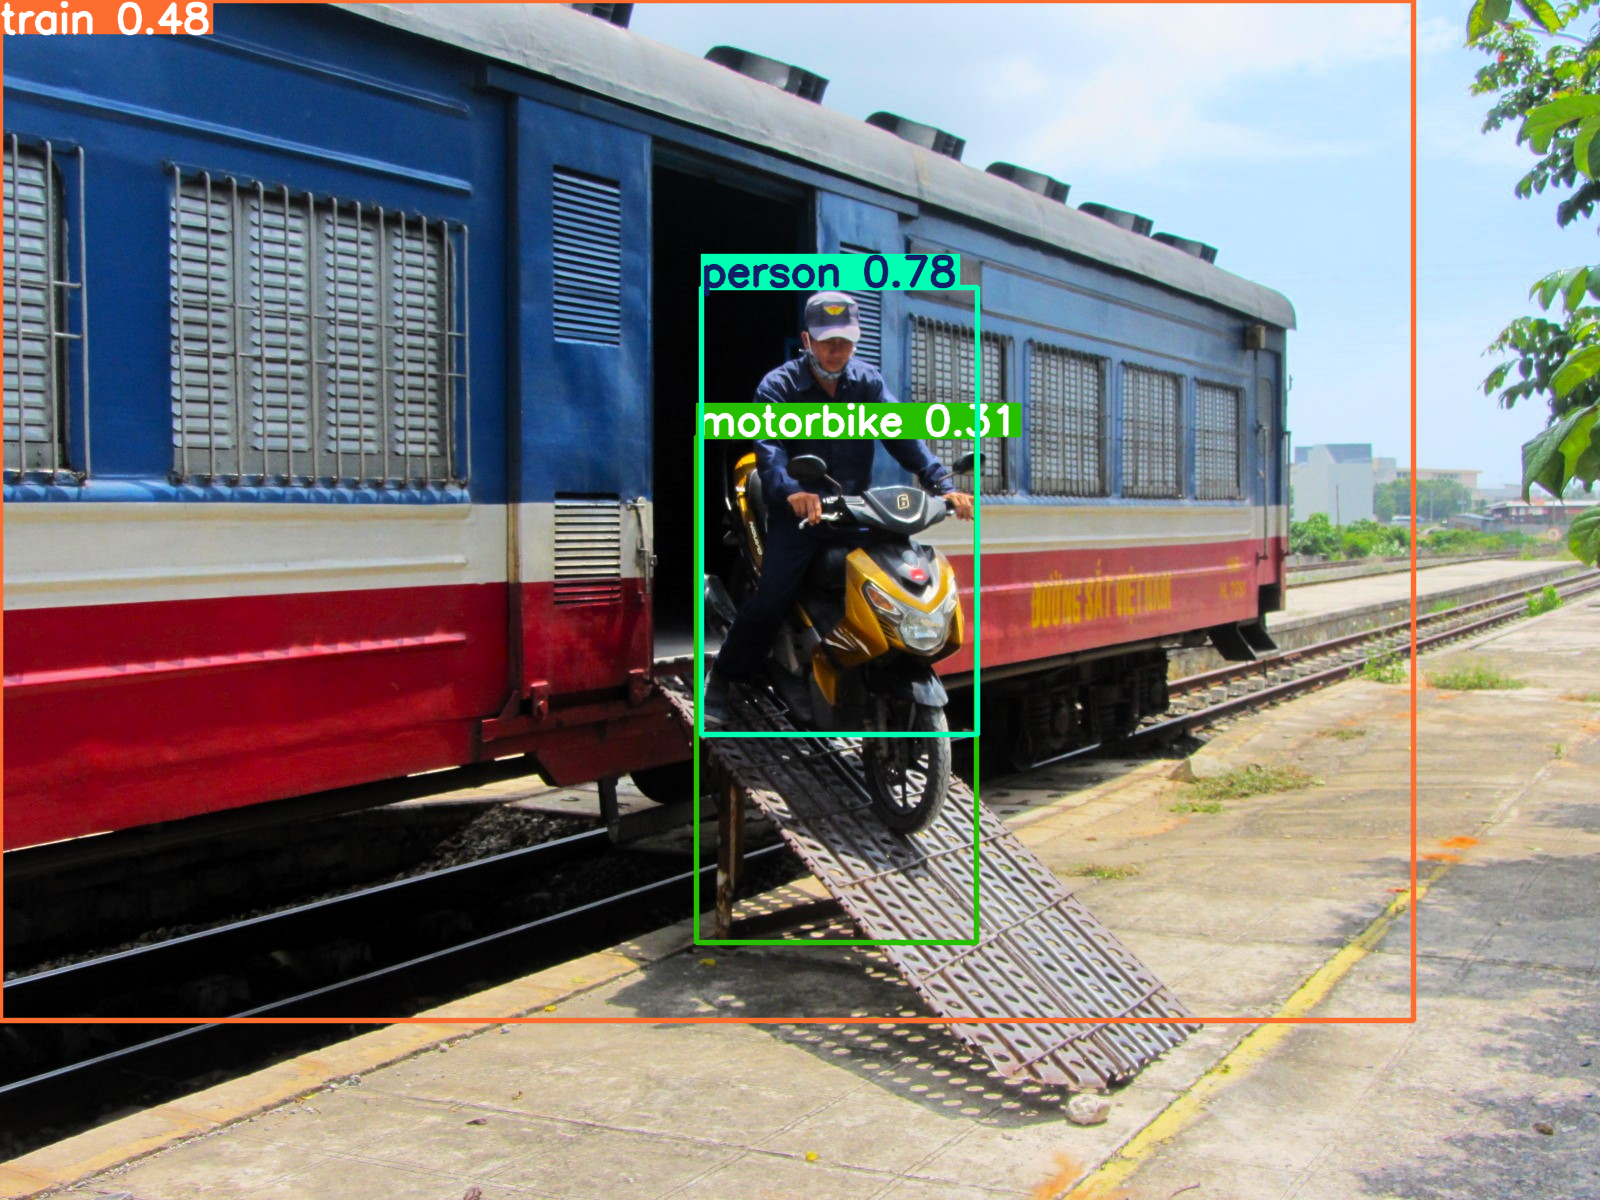

In [65]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

# Loading the trained model
model = YOLO("runs/train/exp/weights/best.pt")

# Path to the test image
test_image = "/content/3example.jpg"

# Running prediction
results = model.predict(source=test_image, save=True, show=False)

result = results[0]

# Showing the image with bounding boxes
result.show()


In [40]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# # Copy the folder to your Drive
# !cp -r /content/yolov8n.pt /content/drive/MyDrive/